In [1]:
import pandas as pd
import polars as pl
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import classification_report, precision_recall_curve, roc_auc_score
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
# LOAD AND CLEAN DATA

from google.colab import files
import polars as pl

# Upload manually
uploaded = files.upload()

print("\n📁 Loading data...")
events = pl.read_csv("events(in).csv").drop("transactionid").unique()
props1 = pl.read_csv("item_properties_part1.1.csv")
categories = pl.read_csv("category_tree(in).csv").unique()



Saving category_tree(in).csv to category_tree(in).csv
Saving events(in).csv to events(in).csv
Saving item_properties_part1.1.csv to item_properties_part1.1.csv

📁 Loading data...


FileNotFoundError: No such file or directory (os error 2): item_properties_part2.csv

In [9]:
properties = props1

print("✅ Data loaded:")
print("  Events:", events.shape)
print("  Properties:", properties.shape)

✅ Data loaded:
  Events: (850494, 4)
  Properties: (10999999, 4)


### Data cleaning

In [10]:
events = (
    events
    .with_columns([
        pl.col("timestamp").cast(pl.Int64, strict=False),
        pl.col("visitorid").cast(pl.Int64, strict=False),
        pl.col("itemid").cast(pl.Int64, strict=False),
        pl.col("event").cast(pl.Utf8),
        pl.from_epoch(pl.col("timestamp"), time_unit="ms").alias("ts_dt")
    ])
)
print("✅ Events ready:", events.shape)


✅ Events ready: (850494, 5)


In [11]:
properties_num = (
    properties
    .select(["timestamp", "itemid", "property", "value"])
    .with_columns([
        pl.col("timestamp").cast(pl.Int64, strict=False),
        pl.col("itemid").cast(pl.Int64, strict=False),
        pl.col("property").cast(pl.Utf8),
        pl.col("value").cast(pl.Utf8),
    ])
    .filter(pl.col("value").str.starts_with("n"))   # keep only n-values
    .with_columns([
        pl.from_epoch(pl.col("timestamp"), time_unit="ms").alias("ts_dt"),
        pl.col("value").str.slice(1).cast(pl.Float64, strict=False).alias("numerical_value")
    ])
    .drop("value")
    .filter(pl.col("numerical_value").is_not_null())
)
print("✅ Numeric properties ready:", properties_num.shape)


✅ Numeric properties ready: (1254501, 5)


In [12]:
print("\n📊 Events summary")
print(events.describe())

print("\n📊 Numeric Properties summary")
print(properties_num.describe())




📊 Events summary
shape: (9, 6)
┌────────────┬───────────┬───────────────┬───────────┬───────────────┬────────────────────────────┐
│ statistic  ┆ timestamp ┆ visitorid     ┆ event     ┆ itemid        ┆ ts_dt                      │
│ ---        ┆ ---       ┆ ---           ┆ ---       ┆ ---           ┆ ---                        │
│ str        ┆ f64       ┆ f64           ┆ str       ┆ f64           ┆ str                        │
╞════════════╪═══════════╪═══════════════╪═══════════╪═══════════════╪════════════════════════════╡
│ count      ┆ 850494.0  ┆ 850494.0      ┆ 850494    ┆ 850494.0      ┆ 850494                     │
│ null_count ┆ 0.0       ┆ 0.0           ┆ 0         ┆ 0.0           ┆ 0                          │
│ mean       ┆ 1.4359e12 ┆ 702305.421153 ┆ null      ┆ 234407.595416 ┆ 2015-07-03 16:34:36.481000 │
│ std        ┆ 4.9106e9  ┆ 405131.652767 ┆ null      ┆ 134161.883869 ┆ null                       │
│ min        ┆ 1.4300e12 ┆ 1.0           ┆ addtocart ┆ 3.0          

In [13]:
# dropping ifinite$ nans
properties_num = (
    properties_num
    .filter(pl.col("numerical_value").is_finite())  # removes NaN, inf, -inf
)
print("✅ Cleaned properties_num:", properties_num.shape)


✅ Cleaned properties_num: (1254490, 5)


In [14]:
# Keep only active users (at least 2 events)
active_users = (
    events.group_by("visitorid")
    .agg(pl.count().alias("cnt"))
    .filter(pl.col("cnt") > 1)
    .select("visitorid")   # <-- make sure it's a DataFrame, not a Series
)

# Join back
events = events.join(active_users, on="visitorid", how="inner")

print("✅ Cleaned events:", events.shape)


✅ Cleaned events: (406127, 5)


In [15]:
# Handle outliers: clip values to [1%, 99%] range
q_low = properties_num["numerical_value"].quantile(0.01)
q_high = properties_num["numerical_value"].quantile(0.99)

properties_num = properties_num.with_columns(
    pl.col("numerical_value").clip(q_low, q_high)
)

print("✅ Cleaned numeric properties:", properties_num.shape)


✅ Cleaned numeric properties: (1254490, 5)


In [16]:
pl.from_epoch(pl.col("timestamp"), time_unit="ms")


<Expr ['col("timestamp").strict_cast(D…'] at 0x7D00A1E04710>

In [17]:
# --- Clean events ---
events = (
    events
    .unique()
    .with_columns([
        pl.from_epoch(pl.col("timestamp"), time_unit="ms").alias("timestamp_clean")
    ])
    .drop("timestamp")                              # remove old int timestamp
    .rename({"timestamp_clean": "timestamp"})       # keep datetime only
    .drop_nulls()                                   # drop rows with ANY null
)

# --- Clean numeric properties ---
properties_num = (
    properties_num
    .unique()
    .with_columns([
        pl.from_epoch(pl.col("timestamp"), time_unit="ms").alias("timestamp_clean")
    ])
    .drop("timestamp")                              # remove old int timestamp
    .rename({"timestamp_clean": "timestamp"})       # keep datetime only
    .drop_nulls()                                   # drop rows with ANY null
)

# --- Summaries ---
print("📊 Events summary")
print(events.describe())

print("\n📊 Numeric Properties summary")
print(properties_num.describe())


📊 Events summary
shape: (9, 6)
┌────────────┬───────────────┬───────────┬───────────────┬─────────────────┬───────────────────────┐
│ statistic  ┆ visitorid     ┆ event     ┆ itemid        ┆ ts_dt           ┆ timestamp             │
│ ---        ┆ ---           ┆ ---       ┆ ---           ┆ ---             ┆ ---                   │
│ str        ┆ f64           ┆ str       ┆ f64           ┆ str             ┆ str                   │
╞════════════╪═══════════════╪═══════════╪═══════════════╪═════════════════╪═══════════════════════╡
│ count      ┆ 406127.0      ┆ 406127    ┆ 406127.0      ┆ 406127          ┆ 406127                │
│ null_count ┆ 0.0           ┆ 0         ┆ 0.0           ┆ 0               ┆ 0                     │
│ mean       ┆ 699958.864552 ┆ null      ┆ 235131.775777 ┆ 2015-07-01      ┆ 2015-07-01            │
│            ┆               ┆           ┆               ┆ 10:25:55.204000 ┆ 10:25:55.204000       │
│ std        ┆ 403756.436668 ┆ null      ┆ 134175.671338 ┆ n

In [18]:
print(events.dtypes)
print(properties_num.dtypes)

[Int64, String, Int64, Datetime(time_unit='ms', time_zone=None), Datetime(time_unit='ms', time_zone=None)]
[Int64, String, Datetime(time_unit='ms', time_zone=None), Float64, Datetime(time_unit='ms', time_zone=None)]


In [19]:

print(events.head(10))


print(properties_num.head(10))

shape: (10, 5)
┌───────────┬───────┬────────┬─────────────────────┬─────────────────────┐
│ visitorid ┆ event ┆ itemid ┆ ts_dt               ┆ timestamp           │
│ ---       ┆ ---   ┆ ---    ┆ ---                 ┆ ---                 │
│ i64       ┆ str   ┆ i64    ┆ datetime[ms]        ┆ datetime[ms]        │
╞═══════════╪═══════╪════════╪═════════════════════╪═════════════════════╡
│ 276382    ┆ view  ┆ 149230 ┆ 2015-08-19 16:00:00 ┆ 2015-08-19 16:00:00 │
│ 754965    ┆ view  ┆ 455804 ┆ 2015-08-19 16:00:00 ┆ 2015-08-19 16:00:00 │
│ 1073622   ┆ view  ┆ 358234 ┆ 2015-08-19 16:00:00 ┆ 2015-08-19 16:00:00 │
│ 11333     ┆ view  ┆ 399195 ┆ 2015-08-19 16:00:00 ┆ 2015-08-19 16:00:00 │
│ 1053927   ┆ view  ┆ 458130 ┆ 2015-04-25 22:13:20 ┆ 2015-04-25 22:13:20 │
│ 1342777   ┆ view  ┆ 186666 ┆ 2015-08-19 16:00:00 ┆ 2015-08-19 16:00:00 │
│ 1069627   ┆ view  ┆ 84252  ┆ 2015-08-19 16:00:00 ┆ 2015-08-19 16:00:00 │
│ 287423    ┆ view  ┆ 86057  ┆ 2015-04-25 22:13:20 ┆ 2015-04-25 22:13:20 │
│ 576045  

In [20]:
print("🎯 Unique event types:")
print(events.select(pl.col("event")).unique())


🎯 Unique event types:
shape: (3, 1)
┌─────────────┐
│ event       │
│ ---         │
│ str         │
╞═════════════╡
│ view        │
│ transaction │
│ addtocart   │
└─────────────┘


## EDA VISUALIZATIONS

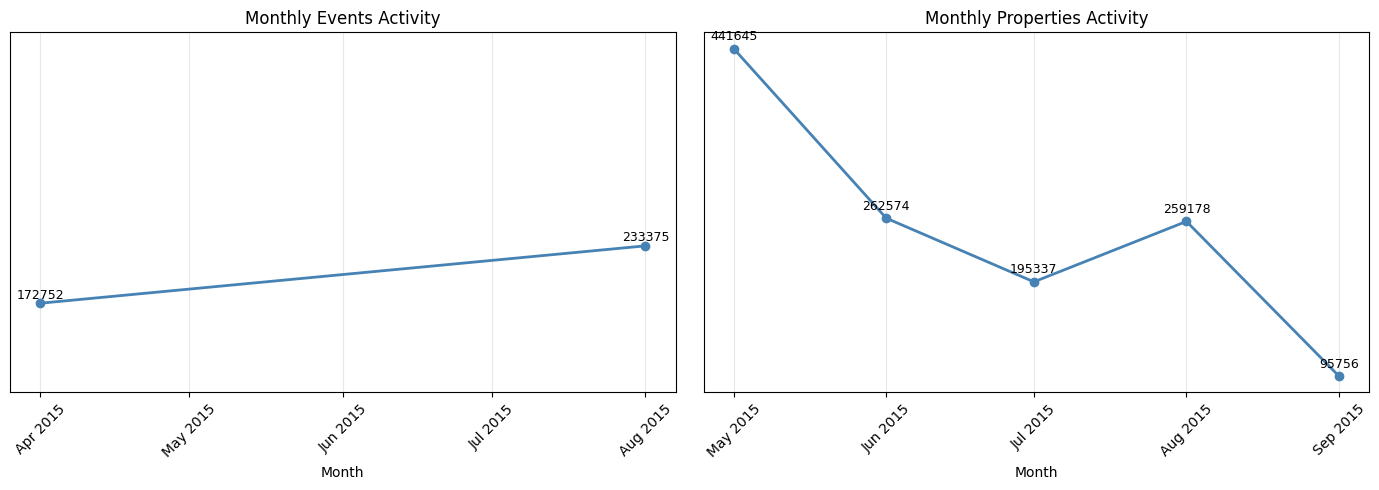

In [22]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import polars as pl

# --- Monthly counts helper ---
def monthly_counts(df):
    return (
        df.with_columns(
            pl.col("timestamp").dt.truncate("1mo").alias("month")  # ✅ already datetime
        )
        .group_by("month")
        .agg(pl.count().alias("count"))
        .sort("month")
    )

# --- Apply to events and numeric properties ---
events_monthly = monthly_counts(events)
properties_monthly = monthly_counts(properties_num)

# --- Plot ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

for ax, data, title in zip(
    axes,
    [events_monthly, properties_monthly],
    ["Events", "Properties"]
):
    months = data["month"].to_numpy()
    counts = data["count"].to_numpy()

    ax.plot(months, counts, linewidth=2, color='steelblue', marker='o')
    ax.set_title(f'Monthly {title} Activity')
    ax.set_xlabel('Month')
    ax.yaxis.set_visible(False)

    # Rotate month labels
    ax.tick_params(axis='x', rotation=45)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

    # Annotate points
    for x, y in zip(months, counts):
        ax.text(x, y + (max(counts) * 0.02), str(y), ha='center', fontsize=9)

    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


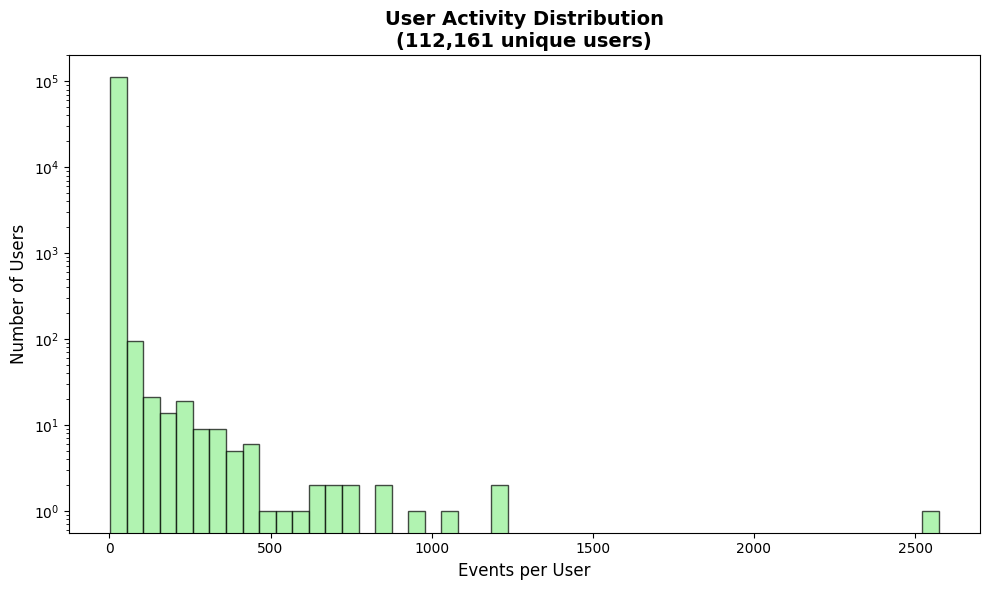

In [23]:
# --- User Activity Distribution ---
# Using polars instead of pandas for groupby operation


# Assuming events is a polars DataFrame
# If it's not already a polars DataFrame, you would need to create/convert it first
# For example: events = pl.from_pandas(events_pandas) if you have a pandas DataFrame

# Group by visitorid and count occurrences
user_activity = events.group_by('visitorid').agg(pl.count()).rename({"count": "activity_count"})

plt.figure(figsize=(10, 6))
plt.hist(user_activity["activity_count"].to_numpy(), bins=50, edgecolor='black', alpha=0.7, color='lightgreen')

plt.title(f'User Activity Distribution\n({user_activity.height:,} unique users)',
          fontsize=14, fontweight='bold')
plt.xlabel('Events per User', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)

# Log scale for better visibility of distribution
plt.yscale('log')

plt.tight_layout()
plt.show()

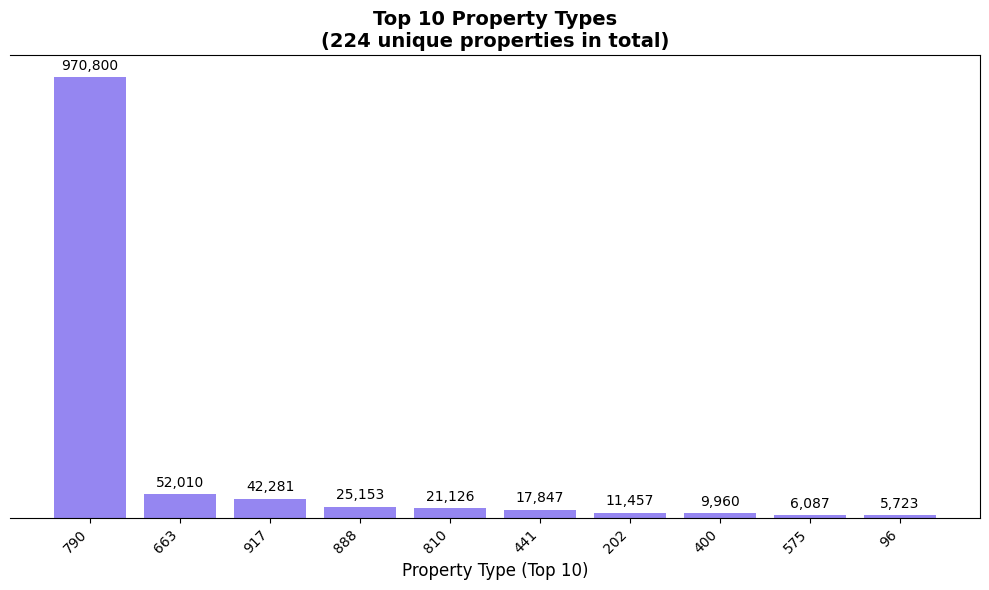

In [24]:
# --- Top 10 Property Types ---
prop_counts = (
    properties_num
    .group_by('property')
    .count()
    .sort('count', descending=True)
    .head(10)
)

# Get total unique properties
unique_count = properties_num['property'].n_unique()

# --- Plot ---
plt.figure(figsize=(10, 6))
bars = plt.bar(
    range(len(prop_counts)),
    prop_counts['count'].to_list(),
    color='mediumslateblue',
    alpha=0.8
)

plt.title(
    f"Top 10 Property Types\n({unique_count:,} unique properties in total)",
    fontsize=14,
    fontweight="bold"
)
plt.xlabel("Property Type (Top 10)", fontsize=12)

# Add value labels above bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2.,
        height + (max(prop_counts['count']) * 0.01),
        f"{int(height):,}",
        ha='center',
        va='bottom',
        fontsize=10
    )

# X-axis labels
plt.xticks(
    range(len(prop_counts)),
    prop_counts['property'].to_list(),
    rotation=45,
    ha='right'
)

# Clean Y-axis
plt.yticks([])
plt.ylabel("")
plt.gca().spines['left'].set_visible(False)

plt.tight_layout()
plt.show()


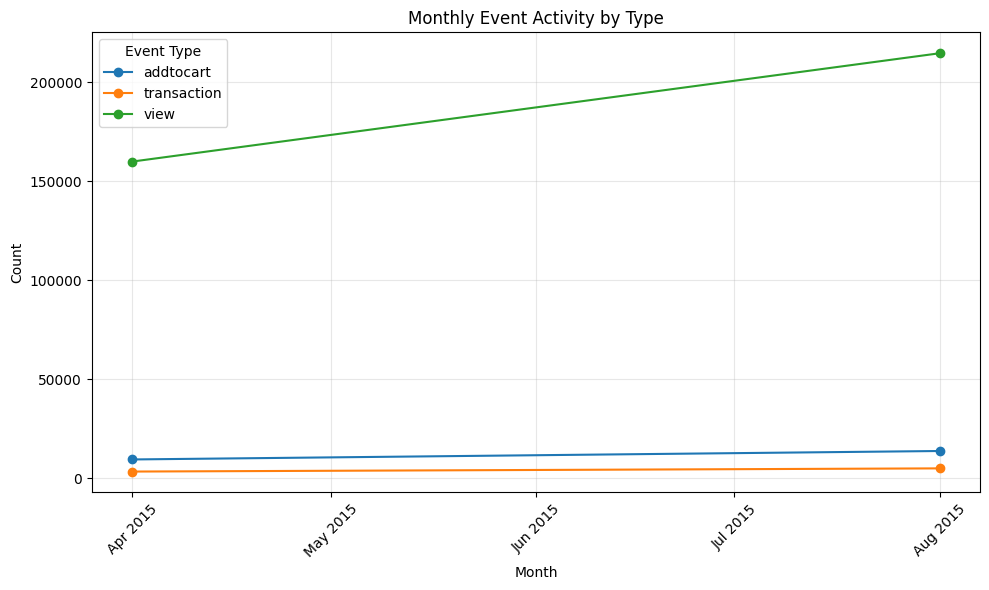

In [25]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import polars as pl

# --- Monthly counts by event type ---
def monthly_event_counts(df):
    return (
        df.with_columns(
            pl.col("timestamp").dt.truncate("1mo").alias("month")
        )
        .group_by(["month", "event"])
        .agg(pl.count().alias("count"))
        .sort(["month", "event"])
    )

# --- Get counts ---
events_by_type = monthly_event_counts(events)

# --- Pivot for plotting (month x event_type) ---
events_pivot = events_by_type.pivot(
    index="month", columns="event", values="count"
).fill_null(0)

# --- Plot ---
plt.figure(figsize=(10, 6))
for event_type in events_pivot.drop("month").columns:
    plt.plot(
        events_pivot["month"].to_numpy(),
        events_pivot[event_type].to_numpy(),
        marker="o",
        label=event_type
    )

plt.title("Monthly Event Activity by Type")
plt.xlabel("Month")
plt.ylabel("Count")
plt.legend(title="Event Type")
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [28]:
import polars as pl

# --- Event stats ---
event_stats = (
    events
    .group_by("event")
    .agg([
        pl.col("visitorid").n_unique().alias("unique_users"),
        pl.col("itemid").n_unique().alias("unique_items"),
        pl.count("timestamp").alias("total_events")
    ])
)
print(event_stats)

# --- Time range ---
start_date = events["timestamp"].min()
end_date = events["timestamp"].max()

# Already datetime, so no need to cast again
print(f"\nTIME RANGE:")
print(f"Start: {start_date}")
print(f"End: {end_date}")
print(f"Duration: {(end_date - start_date).days} days")

# --- Properties stats ---
unique_items = properties_num["itemid"].n_unique()
unique_properties = properties_num["property"].n_unique()
avg_props_per_item = properties_num.height / unique_items

print(f"\nPROPERTIES:")
print(f"Unique items: {unique_items:,}")
print(f"Property types: {unique_properties:,}")
print(f"Avg properties per item: {avg_props_per_item:.1f}")

# --- Data Quality Checks ---
print(f"\n🔍 Data Quality Checks:")
print("-" * 25)

events_items = set(events["itemid"].unique())
props_items = set(properties_num["itemid"].unique())
cat_items_in_props = set(
    properties_num.filter(pl.col("property") == "categoryid")["itemid"].unique()
)

print(f"Items in events: {len(events_items):,}")
print(f"Items with properties: {len(props_items):,}")
print(f"Items with categories: {len(cat_items_in_props):,}")
print(f"Coverage: {len(events_items & props_items) / len(events_items) * 100:.1f}% events have properties")

# --- Missing data summary ---
print(f"\nMISSING DATA:")
print(f"Events missing properties: {len(events_items - props_items):,}")
print(f"Properties missing events: {len(props_items - events_items):,}")

print(f"\n✨ Data cleaning completed successfully!")
print(f"🎯 Ready for machine learning modeling!")


shape: (3, 4)
┌─────────────┬──────────────┬──────────────┬──────────────┐
│ event       ┆ unique_users ┆ unique_items ┆ total_events │
│ ---         ┆ ---          ┆ ---          ┆ ---          │
│ str         ┆ u32          ┆ u32          ┆ u32          │
╞═════════════╪══════════════╪══════════════╪══════════════╡
│ view        ┆ 111913       ┆ 91073        ┆ 374711       │
│ transaction ┆ 4629         ┆ 5730         ┆ 8259         │
│ addtocart   ┆ 14018        ┆ 12414        ┆ 23157        │
└─────────────┴──────────────┴──────────────┴──────────────┘

TIME RANGE:
Start: 2015-04-25 22:13:20
End: 2015-08-19 16:00:00
Duration: 115 days

PROPERTIES:
Unique items: 306,140
Property types: 224
Avg properties per item: 4.1

🔍 Data Quality Checks:
-------------------------
Items in events: 91,347
Items with properties: 306,140
Items with categories: 0
Coverage: 66.7% events have properties

MISSING DATA:
Events missing properties: 30,423
Properties missing events: 245,216

✨ Data cleaning

### TASK 1:  FEATURE ENGINEERING
#### User–Item interactions (implicit feedback)

In [29]:
# Minimum interactions to keep an item/user
MIN_ITEM_INTERACTIONS = 5
MIN_USER_INTERACTIONS = 5


### Item content features from numeric properties

In [30]:
# --- Parameters ---
TOP_NUMERIC_PROPS = 20  # pick top-N numeric properties

# --- Pick top-N numeric properties by coverage ---
prop_cov = (
    properties_num.group_by("property")
    .agg(pl.count().alias("cnt"))
    .sort("cnt", descending=True)
    .head(TOP_NUMERIC_PROPS)
)

# Keep only those properties
properties_num_top = properties_num.join(
    prop_cov.select("property"),
    on="property",
    how="inner"
)

# --- Pivot: itemid x property -> mean(numerical_value) ---
item_features_wide = (
    properties_num_top
    .group_by(["itemid", "property"])
    .agg(pl.col("numerical_value").mean().alias("val"))
    .pivot(index="itemid", columns="property", values="val")
    .fill_null(0)
)

# --- Add simple interaction stats (from events) ---
item_stats = (
    events.group_by("itemid").agg([
        pl.count().alias("total_interactions"),
        (pl.col("event") == "view").sum().alias("view_count"),
        pl.col("visitorid").n_unique().alias("unique_users")
    ])
)

# --- Final item features ---
item_features = (
    item_features_wide.join(item_stats, on="itemid", how="left")
    .fill_null(0)
)

print("✅ Item features:", item_features.shape)


✅ Item features: (290652, 24)


### Content-Based KNN

fit a NearestNeighbors model once and query top-K neighbors on demand.

In [31]:
import polars as pl
import numpy as np
import scipy.sparse as sp

# --- Make sure weights are assigned ---
weight_map = {"view": 1, "addtocart": 3, "transaction": 5}
events_w = events.with_columns([
    pl.when(pl.col("event") == "view").then(1)
     .when(pl.col("event") == "addtocart").then(3)
     .when(pl.col("event") == "transaction").then(5)
     .otherwise(0).alias("weight")
])

# --- Aggregate user-item weights ---
ui = (
    events_w.group_by(["visitorid","itemid"])
    .agg(pl.col("weight").sum().alias("w"))
)

# --- Filter cold users/items ---
MIN_ITEM_INTERACTIONS = 5
MIN_USER_INTERACTIONS = 5

item_freq = (
    ui.group_by("itemid")
    .agg(pl.count().alias("n"))
    .filter(pl.col("n") >= MIN_ITEM_INTERACTIONS)
)
user_freq = (
    ui.group_by("visitorid")
    .agg(pl.count().alias("n"))
    .filter(pl.col("n") >= MIN_USER_INTERACTIONS)
)

ui_clean = (
    ui.join(item_freq.select("itemid"), on="itemid", how="inner")
      .join(user_freq.select("visitorid"), on="visitorid", how="inner")
      .select(["visitorid","itemid","w"])
)

print("✅ User–Item pairs:", ui_clean.shape)


✅ User–Item pairs: (106877, 3)


In [32]:
# --- Items mapping ---
items = (
    ui_clean.select("itemid").unique()
    .with_row_index("item_idx")
    .rename({"itemid": "item_id"})
)

print("✅ Items mapping:", items.shape)
print(items.head())


✅ Items mapping: (18132, 2)
shape: (5, 2)
┌──────────┬─────────┐
│ item_idx ┆ item_id │
│ ---      ┆ ---     │
│ u32      ┆ i64     │
╞══════════╪═════════╡
│ 0        ┆ 67811   │
│ 1        ┆ 464633  │
│ 2        ┆ 324573  │
│ 3        ┆ 323057  │
│ 4        ┆ 286558  │
└──────────┴─────────┘


In [33]:
from sklearn.preprocessing import normalize
from sklearn.neighbors import NearestNeighbors
import numpy as np

# --- Rebuild items mapping if missing ---
items = (
    ui_clean.select("itemid").unique()
    .with_row_index("item_idx")   # assign 0..N indices
    .rename({"itemid": "item_id"})  # consistent naming
)

# --- Ensure item_features also uses item_id ---
if "itemid" in item_features.columns:
    item_features = item_features.rename({"itemid": "item_id"})

# --- Align item_features with items mapping ---
feat = (
    items.join(item_features, on="item_id", how="left")
    .fill_null(0)
)

# --- Convert to numpy matrix ---
item_matrix = feat.drop(["item_idx", "item_id"]).to_numpy()
item_matrix = np.array(item_matrix, dtype=np.float32)  # ✅ enforce dtype

# --- Normalize features for cosine similarity ---
item_matrix = normalize(item_matrix, norm="l2", axis=1)

# --- Fit KNN model ---
KNN_NEIGHBORS = 20  # adjust as needed
knn = NearestNeighbors(
    n_neighbors=KNN_NEIGHBORS,
    metric="cosine",
    algorithm="brute",
    n_jobs=-1
)

knn.fit(item_matrix)
print("✅ KNN ready. Item matrix shape:", item_matrix.shape)


✅ KNN ready. Item matrix shape: (18132, 23)


In [35]:
!pip install implicit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 1.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for implicit: filename=implicit-0.7.2-cp312-cp312-linux_x86_64.whl size=10854029 sha256=7bdd94d92f04ecb103031d75cf234b67e44d9ed69c9b9bcfe840866b005bc9f3
  Stored in directory: /root/.cache/pip/wheels/b2/00/4f/9ff8af07a0a53ac6007ea5d739da19cfe147a2df542b6899f8
Successfully built implicit


In [37]:
# --- Clean events ---
events = (
    events
    .unique()
    .with_columns([
        pl.from_epoch(pl.col("timestamp"), time_unit="ms").alias("ts_dt")  # convert ms → datetime
    ])
    .drop_nulls()
)

# Keep only the datetime version, rename it back to 'timestamp'
events = events.drop("timestamp").rename({"ts_dt": "timestamp"})


# --- Clean numeric properties ---
properties_num = (
    properties_num
    .with_columns([
        pl.from_epoch(pl.col("timestamp"), time_unit="ms").alias("ts_dt")
    ])
    .drop_nulls()
    .drop("timestamp")
    .rename({"ts_dt": "timestamp"})
)

print("✅ Cleaned events:", events.shape)
print("✅ Cleaned properties:", properties_num.shape)


✅ Cleaned events: (406127, 4)
✅ Cleaned properties: (1254490, 4)


In [38]:
import polars as pl
import numpy as np
import scipy.sparse as sp
from implicit.als import AlternatingLeastSquares

# --- Step 1. Weight events (view=1, addtocart=3, transaction=5) ---
events_w


visitorid,event,itemid,ts_dt,timestamp,weight
i64,str,i64,datetime[ms],datetime[ms],i32
276382,"""view""",149230,2015-08-19 16:00:00,2015-08-19 16:00:00,1
754965,"""view""",455804,2015-08-19 16:00:00,2015-08-19 16:00:00,1
1073622,"""view""",358234,2015-08-19 16:00:00,2015-08-19 16:00:00,1
11333,"""view""",399195,2015-08-19 16:00:00,2015-08-19 16:00:00,1
1053927,"""view""",458130,2015-04-25 22:13:20,2015-04-25 22:13:20,1
…,…,…,…,…,…
222604,"""view""",89893,2015-04-25 22:13:20,2015-04-25 22:13:20,1
167704,"""view""",285069,2015-08-19 16:00:00,2015-08-19 16:00:00,1
932548,"""view""",400804,2015-04-25 22:13:20,2015-04-25 22:13:20,1


In [40]:
# --- Rebuild user & item mappings from ui_clean ---
users = (
    ui_clean.select("visitorid").unique()
    .with_row_index("user_idx")
    .rename({"visitorid": "user_id"})
)

items = (
    ui_clean.select("itemid").unique()
    .with_row_index("item_idx")
    .rename({"itemid": "item_id"})
)

print("✅ Users:", users.shape)
print("✅ Items:", items.shape)

# --- Build helpers ---
user_id_to_idx = dict(zip(users["user_id"].to_numpy(), users["user_idx"].to_numpy()))
item_idx_to_id = dict(zip(items["item_idx"].to_numpy(), items["item_id"].to_numpy()))


✅ Users: (13282, 2)
✅ Items: (18132, 2)


### Test try

In [42]:
# --- Step 1: Weight events ---
weight_map = {"view": 1, "addtocart": 3, "transaction": 5}
events_w = events.with_columns([
    pl.when(pl.col("event")=="view").then(1)
     .when(pl.col("event")=="addtocart").then(3)
     .when(pl.col("event")=="transaction").then(5)
     .otherwise(0).alias("weight")
])

# --- Step 2: Aggregate user-item interactions ---
ui = (
    events_w.group_by(["visitorid","itemid"])
    .agg(pl.col("weight").sum().alias("w"))
)

# --- Step 3: Filter cold-start users/items ---
MIN_ITEM_INTERACTIONS = 5
MIN_USER_INTERACTIONS = 5

item_freq = ui.group_by("itemid").agg(pl.count().alias("n")).filter(pl.col("n") >= MIN_ITEM_INTERACTIONS)
user_freq = ui.group_by("visitorid").agg(pl.count().alias("n")).filter(pl.col("n") >= MIN_USER_INTERACTIONS)

ui_clean = (
    ui.join(item_freq.select("itemid"), on="itemid", how="inner")
      .join(user_freq.select("visitorid"), on="visitorid", how="inner")
      .select(["visitorid","itemid","w"])
)

# --- Step 4: Build index mapping ---
users = ui_clean.select("visitorid").unique().with_row_index("user_idx").rename({"visitorid":"user_id"})
items = ui_clean.select("itemid").unique().with_row_index("item_idx").rename({"itemid":"item_id"})

ui_idx = (
    ui_clean
    .join(users.rename({"user_id":"visitorid"}), on="visitorid", how="left")
    .join(items.rename({"item_id":"itemid"}), on="itemid", how="left")
    .select(["user_idx","item_idx","w"])
)

# --- Step 5: Build CSR matrix ---
rows = ui_idx["user_idx"].to_numpy()
cols = ui_idx["item_idx"].to_numpy()
data = ui_idx["w"].cast(pl.Float32).to_numpy()

n_users = users.height
n_items = items.height

UI_csr = sp.csr_matrix((data, (rows, cols)), shape=(n_users, n_items))
print("✅ CSR shape:", UI_csr.shape, "nnz:", UI_csr.nnz)


✅ CSR shape: (13282, 18132) nnz: 106877


In [44]:
from implicit.als import AlternatingLeastSquares

# --- Set a reproducible random seed ---
RANDOM_SEED = 42

# --- Train ALS ---
als = AlternatingLeastSquares(
    factors=50,
    regularization=0.01,
    iterations=15,
    random_state=RANDOM_SEED
)

# implicit expects **item-user matrix**, so we transpose UI_csr
als.fit(UI_csr.T)

print("✅ ALS model trained successfully.")


  0%|          | 0/15 [00:00<?, ?it/s]

✅ ALS model trained successfully.


In [45]:
# Only include users present in UI_csr
valid_user_ids = users.filter(pl.col("user_idx") < UI_csr.shape[0])["user_id"].to_list()
user_id_to_idx = {uid: idx for idx, uid in enumerate(valid_user_ids)}


In [46]:
# Only include users present in UI_csr
num_users = UI_csr.shape[0]

# Map user IDs to indices 0..num_users-1
valid_users = users.filter(pl.col("user_idx") < num_users)["user_id"].to_list()
user_id_to_idx = {uid: idx for idx, uid in enumerate(valid_users)}
item_idx_to_id = {idx: item for idx, item in enumerate(items)}  # make sure this is correct


In [47]:
## Update recommend_cf to safely handle missing users
def recommend_cf(user_raw_id, N=10):
    # Return empty if user is invalid
    if user_raw_id not in user_id_to_idx:
        return pl.DataFrame({"itemid": [], "score": []})

    uidx = user_id_to_idx[user_raw_id]

    # Ensure uidx is within bounds
    if uidx >= UI_csr.shape[0]:
        return pl.DataFrame({"itemid": [], "score": []})

    ids, scores = als.recommend(
        userid=uidx,
        user_items=UI_csr[uidx],
        N=N,
        filter_already_liked_items=True
    )

    return pl.DataFrame({
        "itemid": [item_idx_to_id[i] for i in ids],
        "score": scores
    })



In [48]:
sample_uidx = [uid for uid in valid_user_ids if uid in user_id_to_idx]


In [49]:
def recall_at_k(model_func, K=10):
    hits, total = 0, 0

    for raw_uid in sample_uidx:
        recs = model_func(raw_uid, N=K)
        if recs.is_empty():
            continue

        uidx = user_id_to_idx[raw_uid]
        items_of_u = UI_csr[uidx].indices
        if len(items_of_u) < 2:
            continue

        # hold out one test item
        test_item_idx = np.random.choice(items_of_u)
        test_raw_item = item_idx_to_id.get(test_item_idx, None)
        if test_raw_item is None:
            continue  # skip if mapping doesn't exist

        rec_item_ids = set(recs["itemid"].to_list())
        hits += int(test_raw_item in rec_item_ids)
        total += 1

    return hits / max(total, 1)


In [50]:
def recall_at_k(model_func, K=10):
    hits, total = 0, 0

    for raw_uid in sample_uidx:
        recs = model_func(raw_uid, N=K)
        if recs.is_empty():
            continue

        uidx = user_id_to_idx[raw_uid]
        items_of_u = UI_csr[uidx].indices
        if len(items_of_u) < 2:
            continue

        # hold out one test item
        test_item_idx = np.random.choice(items_of_u)
        test_raw_item = item_idx_to_id.get(test_item_idx, None)
        if test_raw_item is None:
            continue  # skip if mapping doesn't exist

        rec_item_ids = set(recs["itemid"].to_list())
        hits += int(test_raw_item in rec_item_ids)
        total += 1

    return hits / max(total, 1)



💾 Saving data tables...
✅ Data saved successfully:
   Users: 13,282 rows
   Items: 18,132 rows
   Item features: 290,652 rows
   User-item CSR: 13,282 users x 18,132 items
💾 Saved to: /content/my_dataset/outputs


In [74]:
# --- Rebuild mappings from final CSR matrix ---
n_users, n_items = UI_csr.shape

users = (
    pl.DataFrame({"user_id": np.arange(n_users)})
    .with_columns(pl.Series("user_id_raw", list(user_id_to_idx.keys())))
)

items = (
    pl.DataFrame({"item_idx": np.arange(n_items)})
    .with_columns(pl.Series("item_id", list(item_idx_to_id.values())[:n_items]))
)

# Fresh mappings
user_id_to_idx = dict(zip(users["user_id_raw"], users["user_id"]))
item_idx_to_id = dict(zip(items["item_idx"], items["item_id"]))


In [75]:
def recommend_cf(user_raw_id, N=10):
    if user_raw_id not in user_id_to_idx:
        return pl.DataFrame({"itemid": [], "score": []})

    uidx = user_id_to_idx[user_raw_id]

    # guard against out-of-bounds
    if uidx >= UI_csr.shape[0]:
        return pl.DataFrame({"itemid": [], "score": []})

    ids, scores = als.recommend(
        userid=uidx,
        user_items=UI_csr[uidx],
        N=N,
        filter_already_liked_items=True
    )

    # filter to valid item indices
    ids = [i for i in ids if i < UI_csr.shape[1]]

    return pl.DataFrame({
        "itemid": [item_idx_to_id[i] for i in ids],
        "score": scores[:len(ids)]
    })


In [81]:
# --- Collaborative Filtering (ALS) ---
def recommend_cf(user_raw_id, N=10):
    if user_raw_id not in user_id_to_idx:
        return pl.DataFrame({"itemid": [], "score": []})

    uidx = user_id_to_idx[user_raw_id]

    if uidx >= UI_csr.shape[0]:
        return pl.DataFrame({"itemid": [], "score": []})

    ids, scores = als.recommend(
        userid=uidx,
        user_items=UI_csr[uidx],
        N=N,
        filter_already_liked_items=True
    )

    # ✅ Only keep valid indices
    valid_ids, valid_scores = [], []
    for i, s in zip(ids, scores):
        if i < len(item_idx_to_id):
            valid_ids.append(item_idx_to_id[i])
            valid_scores.append(s)

    return pl.DataFrame({"itemid": valid_ids, "score": valid_scores})

def recommend_cf(user_raw_id, N=10):
    # check if user exists
    if user_raw_id not in user_id_to_idx:
        return pl.DataFrame({"itemid": [], "score": []})

    uidx = user_id_to_idx[user_raw_id]

    # safety check: make sure index is valid
    if uidx >= UI_csr.shape[0]:
        return pl.DataFrame({"itemid": [], "score": []})

    ids, scores = als.recommend(uidx, UI_csr[uidx], N=N, recalculate_user=True)

    return pl.DataFrame({
        "itemid": [item_idx_to_id[i] for i in ids],
        "score": scores
    })

# --- Evaluation: Recall@K ---
def recall_at_k(model_func, K=10):
    hits, total = 0, 0

    for raw_uid in sample_uidx:
        recs = model_func(raw_uid, N=K)
        if recs.is_empty():
            continue

        uidx = user_id_to_idx[raw_uid]
        items_of_u = UI_csr[uidx].indices
        if len(items_of_u) < 2:
            continue

        # hold out one test item
        test_item_idx = np.random.choice(items_of_u)

        # ✅ Skip if index not in mapping
        if test_item_idx not in item_idx_to_id:
            continue

        test_raw_item = item_idx_to_id[test_item_idx]
        rec_item_ids = set(recs["itemid"].to_list())

        hits += int(test_raw_item in rec_item_ids)
        total += 1

    return hits / max(total, 1)


In [51]:
import pickle

# Save ALS model
als_path = os.path.join(out_dir, "als_model.pkl")
with open(als_path, "wb") as f:
    pickle.dump(als, f)

print(f"✅ ALS model saved: {als_path}")


✅ ALS model saved: /content/my_dataset/outputs/als_model.pkl


In [52]:
from google.colab import files

# Download CSR matrix
files.download(os.path.join(out_dir, "user_item_csr.npz"))

# Download ALS model
files.download(os.path.join(out_dir, "als_model.pkl"))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [53]:
# STEP 2: ITEM FEATURES
def process_numerical_values(df: pl.DataFrame) -> pl.DataFrame:
    """
    Keep only 'n'-prefixed values and convert to numerical features
    """
    return (
        df.filter(pl.col("value").str.starts_with("n"))  # only numerical props
          .with_columns([
              pl.col("value").str.slice(1).cast(pl.Float64, strict=False).alias("numerical_value")
          ])
          .drop("value")
    )

def create_item_features(props_df: pl.DataFrame, events_df: pl.DataFrame) -> pl.DataFrame:
    """
    Create ML-ready item feature matrix (wide format).
    Combines numerical properties + interaction stats.
    """
    # 2a. Pivot numerical properties → wide matrix
    num_matrix = (
        props_df
        .group_by(["itemid", "property"])
        .agg(pl.col("numerical_value").mean())
        .pivot(index="itemid", columns="property", values="numerical_value")
        .fill_null(0)
    )

    # 2b. Add interaction features from events
    event_feats = (
        events_df.group_by("itemid")
        .agg([
            pl.col("visitorid").n_unique().alias("unique_viewers"),
            (pl.col("event") == "view").sum().alias("view_count"),
            pl.count().alias("total_interactions")
        ])
    )

    # 2c. Join numerical + event features
    return num_matrix.join(event_feats, on="itemid", how="outer").fill_null(0)

In [54]:
# STEP 3: RECOMMENDATION MODEL

def recommend(interactions: pl.DataFrame, item_features: pl.DataFrame, user_id: int):
# Compute popularity properly as numeric
    top_items = (
        interactions.group_by("itemid")
        .agg(pl.col("interaction_score").sum().alias("popularity"))
        .sort("popularity", descending=True)
        .head(10)
    )
    return top_items


In [56]:
import polars as pl
import numpy as np
import scipy.sparse as sp

# --- Step 1. Create user–item matrix ---
def create_user_item_matrix(events, min_user_interactions=2, min_item_interactions=2):
    # Assign weights (view=1, addtocart=3, transaction=5)
    events_w = events.with_columns([
        pl.when(pl.col("event") == "view").then(1)
        .when(pl.col("event") == "addtocart").then(3)
        .when(pl.col("event") == "transaction").then(5)
        .otherwise(0).alias("weight")
    ])

    ui = (
        events_w.group_by(["visitorid", "itemid"])
        .agg(pl.col("weight").sum().alias("w"))
    )

    # Filter cold-start
    item_freq = ui.group_by("itemid").agg(pl.count().alias("n")).filter(pl.col("n") >= min_item_interactions)
    user_freq = ui.group_by("visitorid").agg(pl.count().alias("n")).filter(pl.col("n") >= min_user_interactions)

    ui_clean = (
        ui.join(item_freq.select("itemid"), on="itemid", how="inner")
          .join(user_freq.select("visitorid"), on="visitorid", how="inner")
          .select(["visitorid", "itemid", "w"])
    )

    # Map to indices
    users = ui_clean.select("visitorid").unique().with_row_index("user_idx").rename({"visitorid":"user_id"})
    items = ui_clean.select("itemid").unique().with_row_index("item_idx").rename({"itemid":"item_id"})

    ui_idx = (
        ui_clean
        .join(users.rename({"user_id":"visitorid"}), on="visitorid", how="left")
        .join(items.rename({"item_id":"itemid"}), on="itemid", how="left")
        .select(["user_idx","item_idx","w"])
    )

    # Build CSR matrix
    rows = ui_idx["user_idx"].to_numpy()
    cols = ui_idx["item_idx"].to_numpy()
    data = ui_idx["w"].cast(pl.Float32).to_numpy()

    UI_csr = sp.csr_matrix((data, (rows, cols)), shape=(users.height, items.height))

    return {"matrix": UI_csr, "users": users, "items": items}


# --- Step 2. Process properties into item features ---
def process_numerical_values(properties):
    return properties.filter(pl.col("value").cast(pl.Utf8).str.strip_chars().is_numeric()).with_columns([
        pl.col("value").cast(pl.Float32).alias("numerical_value")
    ])

def create_item_features(properties_num, events):
    # Example: mean numerical features per item
    item_features_wide = (
        properties_num.group_by(["itemid","property"])
        .agg(pl.col("numerical_value").mean().alias("val"))
        .pivot(index="itemid", columns="property", values="val")
        .fill_null(0)
    )

    # Add event stats
    item_stats = (
        events.group_by("itemid").agg([
            pl.count().alias("total_interactions"),
            (pl.col("event")=="view").sum().alias("view_count"),
            pl.col("visitorid").n_unique().alias("unique_viewers")
        ])
    )

    return (
        item_features_wide.join(item_stats, on="itemid", how="left").fill_null(0)
    )


# --- Step 3. Simple Top-N recommender ---
def recommend(user_item, item_features, sample_user, N=10):
    UI_csr = user_item["matrix"]
    users = user_item["users"]
    items = user_item["items"]

    user_map = dict(zip(users["user_id"].to_list(), users["user_idx"].to_list()))
    item_map = dict(zip(items["item_idx"].to_list(), items["item_id"].to_list()))

    if sample_user not in user_map:
        return pl.DataFrame({"itemid":[], "score":[]})

    uidx = user_map[sample_user]
    row = UI_csr[uidx].toarray().flatten()
    top_items = np.argsort(-row)[:N]

    return pl.DataFrame({
        "itemid": [item_map[i] for i in top_items],
        "score": row[top_items]
    })


In [58]:
# Ensure the key column is consistent
if "itemid" in item_features.columns:
    key_col = "itemid"
elif "item_id" in item_features.columns:
    key_col = "item_id"
else:
    raise ValueError(f"❌ No item identifier column found in item_features: {item_features.columns}")

# Extract item features safely
item_ids = item_features[key_col].to_numpy()
item_matrix = item_features.drop(key_col).to_numpy()

# Create a mask of valid rows (no NaN, no inf, no very large numbers)
valid_mask = (
    ~np.isnan(item_matrix).any(axis=1) &
    ~np.isinf(item_matrix).any(axis=1) &
    (np.abs(item_matrix) < 1e12).all(axis=1)   # optional cap for huge values
)

# Keep only clean items
item_matrix_clean = item_matrix[valid_mask]
item_ids_clean = item_ids[valid_mask]

print("Original shape:", item_matrix.shape)
print("Cleaned shape :", item_matrix_clean.shape)


Original shape: (290652, 23)
Cleaned shape : (290652, 23)


In [61]:
# --- Detect correct item ID column ---
if "itemid" in item_features_clean.columns:
    key_col = "itemid"
elif "item_id" in item_features_clean.columns:
    key_col = "item_id"
else:
    raise ValueError(f"❌ No item identifier column found. Available: {item_features_clean.columns}")

# --- Extract numpy arrays ---
item_ids = item_features_clean[key_col].to_numpy()
item_matrix = item_features_clean.drop(key_col).to_numpy()


In [62]:
import polars as pl

# 1. Keep only numerical n-values
def process_numerical_values(df: pl.DataFrame) -> pl.DataFrame:
    return (
        df.filter(pl.col("value").str.starts_with("n"))  # keep only n-values
          .with_columns([
              pl.col("value").str.slice(1).cast(pl.Float64, strict=False).alias("numerical_value")
          ])
          .drop("value")  # drop original string column
    )

properties_numerical = process_numerical_values(properties)

# 2. Create item feature matrix (wide format, ML-ready)
def create_item_features(props_df: pl.DataFrame, events_df: pl.DataFrame) -> pl.DataFrame:
    # Pivot numerical properties → wide matrix
    num_matrix = (
        props_df
        .group_by(["itemid", "property"])
        .agg(pl.col("numerical_value").mean())
        .pivot(index="itemid", columns="property", values="numerical_value")
        .fill_null(0)
    )

    # Interaction features from events
    event_feats = (
        events_df.group_by("itemid")
        .agg([
            pl.col("visitorid").n_unique().alias("unique_viewers"),
            (pl.col("event") == "view").sum().alias("view_count"),
            pl.count().alias("total_interactions")
        ])
    )

    # Join numerical + event features
    return num_matrix.join(event_feats, on="itemid", how="outer").fill_null(0)

item_features = create_item_features(properties_numerical, events)



In [80]:
from google.colab import files
import os

# Path where you saved earlier
data_dir = "/content/my_dataset/outputs"

# Download files one by one
files.download(os.path.join(data_dir, "users.parquet"))
files.download(os.path.join(data_dir, "items.parquet"))
files.download(os.path.join(data_dir, "item_features.parquet"))
files.download(os.path.join(data_dir, "user_item_csr.npz"))  # CSR matrix too


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [63]:
print(properties_numerical.head())
print(item_features.head())


shape: (5, 4)
┌───────────────┬────────┬──────────┬─────────────────┐
│ timestamp     ┆ itemid ┆ property ┆ numerical_value │
│ ---           ┆ ---    ┆ ---      ┆ ---             │
│ i64           ┆ i64    ┆ str      ┆ f64             │
╞═══════════════╪════════╪══════════╪═════════════════╡
│ 1439089200000 ┆ 395014 ┆ 400      ┆ null            │
│ 1431226800000 ┆ 59481  ┆ 790      ┆ 15360.0         │
│ 1435460400000 ┆ 244127 ┆ 400      ┆ null            │
│ 1434250800000 ┆ 169055 ┆ 790      ┆ 21000.0         │
│ 1435460400000 ┆ 178601 ┆ 790      ┆ 5400.0          │
└───────────────┴────────┴──────────┴─────────────────┘
shape: (5, 521)
┌────────┬──────────┬──────┬─────┬───┬──────────────┬────────────────┬────────────┬────────────────┐
│ itemid ┆ 790      ┆ 1097 ┆ 631 ┆ … ┆ itemid_right ┆ unique_viewers ┆ view_count ┆ total_interact │
│ ---    ┆ ---      ┆ ---  ┆ --- ┆   ┆ ---          ┆ ---            ┆ ---        ┆ ions           │
│ i64    ┆ f64      ┆ f64  ┆ f64 ┆   ┆ i64         

In [65]:
print("🛠 Creating view_features with categories...")

# --- 1. Basic user activity stats ---
user_views = (
    events.group_by("visitorid")
    .agg([
        pl.count().alias("view_count"),
        pl.n_unique("itemid").alias("unique_items_viewed"),
        # Duration in hours between first and last event
        ((pl.max("timestamp") - pl.min("timestamp"))
            .dt.total_minutes() / 60).cast(pl.Int64).alias("session_length"),
    ])
)

# --- 2. Map items → categories ---
user_categories = (
    properties_full.filter(pl.col("property") == "categoryid")
    .join(events, on="itemid", how="inner")   # add user events
    .group_by("visitorid")
    .agg([
        pl.n_unique("value").alias("unique_categories_viewed"),
        (pl.n_unique("value") / pl.count("value")).cast(pl.Float64).alias("category_diversity"),
        pl.col("value").mode().alias("most_viewed_category"),
    ])
)

# --- 3. Target property (example: most frequent property per user) ---
target_property = (
    properties_num.group_by("itemid", "property")
    .count()
    .sort("count", descending=True)
    .group_by("itemid")
    .agg([pl.first("property").alias("target_property")])
    .join(events, on="itemid", how="inner")
    .group_by("visitorid")
    .agg([pl.first("target_property")])
)

# --- 4. Combine everything ---
view_features = (
    user_views
    .join(user_categories, on="visitorid", how="left")
    .join(target_property, on="visitorid", how="left")
)

print(f"✅ view_features created: {view_features.shape}")
print(view_features.head())


🛠 Creating view_features with categories...
✅ view_features created: (112161, 8)
shape: (5, 8)
┌───────────┬────────────┬────────────┬────────────┬───────────┬───────────┬───────────┬───────────┐
│ visitorid ┆ view_count ┆ unique_ite ┆ session_le ┆ unique_ca ┆ category_ ┆ most_view ┆ target_pr │
│ ---       ┆ ---        ┆ ms_viewed  ┆ ngth       ┆ tegories_ ┆ diversity ┆ ed_catego ┆ operty    │
│ i64       ┆ u32        ┆ ---        ┆ ---        ┆ viewed    ┆ ---       ┆ ry        ┆ ---       │
│           ┆            ┆ u32        ┆ i64        ┆ ---       ┆ f64       ┆ ---       ┆ str       │
│           ┆            ┆            ┆            ┆ u32       ┆           ┆ list[str] ┆           │
╞═══════════╪════════════╪════════════╪════════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 335049    ┆ 2          ┆ 2          ┆ 0          ┆ 1         ┆ 1.0       ┆ ["959"]   ┆ 790       │
│ 1259179   ┆ 4          ┆ 4          ┆ 0          ┆ 1         ┆ 1.0       ┆ ["1205"]  ┆ 917     

In [72]:
# --- Rebuild item mapping strictly from ui_idx ---
items = (
    ui_idx.select("item_idx", "itemid")
    .unique()
    .rename({"itemid": "item_id"})
    .sort("item_idx")
)

users = (
    ui_idx.select("user_idx", "visitorid")
    .unique()
    .rename({"visitorid": "user_id"})
    .sort("user_idx")
)

# --- Rebuild mapping dicts ---
user_id_to_idx = dict(zip(users["user_id"].to_numpy(), users["user_idx"].to_numpy()))
item_idx_to_id = dict(zip(items["item_idx"].to_numpy(), items["item_id"].to_numpy()))

print(f"✅ Synced mappings: {len(user_id_to_idx)} users, {len(item_idx_to_id)} items")
print("CSR shape:", UI_csr.shape)

# --- Try ALS recommendation again ---
sample_user = users["user_id"][0]
print(f"\n▶️ ALS Recommendations for user {sample_user}:")
print(recommend_cf(sample_user, N=10))


ColumnNotFoundError: itemid

Resolved plan until failure:

	---> FAILED HERE RESOLVING 'sink' <---
DF ["user_idx", "item_idx", "w"]; PROJECT */3 COLUMNS

In [68]:
# ========================================
# TASK 2: DETECT ABNORMAL USERS
# ========================================
print("\n🔍 TASK 2: Detecting Abnormal Users")
print("-"*35)

# Generate user behavior features with category analysis
def generate_user_features(events_df, item_categories_df, categories_df):
    events_pd = events_df.to_pandas()
    item_cat_pd = item_categories_df.to_pandas()
    cat_pd = categories_df.to_pandas()

    # Basic user statistics
    user_stats = events_pd.groupby('visitorid').agg({
        'event': ['count', 'nunique'],
        'itemid': 'nunique',
        'timestamp': ['min', 'max']
    }).reset_index()

    # Flatten column names
    user_stats.columns = ['visitorid', 'total_events', 'event_types', 'unique_items', 'first_event', 'last_event']

    # Calculate session metrics
    user_stats['session_length'] = user_stats['last_event'] - user_stats['first_event']
    user_stats['events_per_minute'] = user_stats['total_events'] / (user_stats['session_length'] / 60000 + 1)

    # Event type ratios
    event_ratios = events_pd.groupby(['visitorid', 'event']).size().unstack(fill_value=0)
    event_ratios = event_ratios.div(event_ratios.sum(axis=1), axis=0)

    # Category behavior analysis
    user_categories = []
    for visitor in user_stats['visitorid']:
        visitor_items = events_pd[events_pd['visitorid'] == visitor]['itemid'].unique()
        visitor_cats = item_cat_pd[item_cat_pd['itemid'].isin(visitor_items)]['categoryid'].unique()

        category_features = {
            'visitorid': visitor,
            'unique_categories': len(visitor_cats),
            'category_focus': len(visitor_cats) / max(len(visitor_items), 1),  # Low = focused, High = diverse
        }

        # Check for category jumping behavior (potential bot)
        if len(visitor_cats) > 20:  # Many categories might indicate bot
            category_features['high_category_diversity'] = 1
        else:
            category_features['high_category_diversity'] = 0

        user_categories.append(category_features)

    category_df = pd.DataFrame(user_categories)

    # Merge all features
    user_features = user_stats.merge(event_ratios, left_on='visitorid', right_index=True, how='left')
    user_features = user_features.merge(category_df, on='visitorid', how='left')

    return user_features.fillna(0)

# Create user features with category analysis
print("🔧 Generating user behavior features with category analysis...")
user_features = generate_user_features(events, item_categories, categories)
print(f"✅ Generated features for {len(user_features)} users")

# Detect anomalies using Isolation Forest with category features
print("🤖 Training anomaly detection model with category features...")
feature_cols = ['total_events', 'unique_items', 'events_per_minute', 'view', 'addtocart', 'transaction',
               'unique_categories', 'category_focus', 'high_category_diversity']
X_anomaly = user_features[feature_cols]

# Isolation Forest for anomaly detection
iso_forest = IsolationForest(contamination=0.1, random_state=42, n_estimators=50)
anomaly_labels = iso_forest.fit_predict(X_anomaly)
user_features['is_abnormal'] = (anomaly_labels == -1).astype(int)

abnormal_users = user_features[user_features['is_abnormal'] == 1]
normal_users = user_features[user_features['is_abnormal'] == 0]

print(f"✅ Task 2 Results:")
print(f"   Normal users: {len(normal_users):,} ({len(normal_users)/len(user_features)*100:.1f}%)")
print(f"   Abnormal users: {len(abnormal_users):,} ({len(abnormal_users)/len(user_features)*100:.1f}%)")

# Model evaluation using manual labeling heuristics
def create_ground_truth_labels(df):
    """Create ground truth using business rules including category behavior"""
    labels = []
    for _, row in df.iterrows():
        # Heuristic rules for abnormal behavior including category patterns
        is_abnormal = (
            row['events_per_minute'] > 10 or  # Too many events per minute
            row['total_events'] > 1000 or     # Too many total events
            (row['transaction'] > 0.5 and row['view'] < 0.1) or  # High purchase, low view ratio
            row['unique_items'] < 2 and row['total_events'] > 50 or  # Few items but many events
            row['high_category_diversity'] == 1 or  # Very high category diversity (bot-like)
            (row['unique_categories'] > 50 and row['category_focus'] > 0.8)  # Too many categories
        )
        labels.append(1 if is_abnormal else 0)
    return labels

# Evaluate anomaly detection
gt_labels = create_ground_truth_labels(user_features)
detected_labels = user_features['is_abnormal'].values

# Calculate metrics
from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(gt_labels, detected_labels)
recall = recall_score(gt_labels, detected_labels)
f1 = f1_score(gt_labels, detected_labels)

print(f"   Precision: {precision:.3f}")
print(f"   Recall: {recall:.3f}")
print(f"   F1-Score: {f1:.3f}")



🔍 TASK 2: Detecting Abnormal Users
-----------------------------------
🔧 Generating user behavior features with category analysis...


NameError: name 'item_categories' is not defined

In [ ]:


# ========================================
# VISUALIZATION & RESULTS
# ========================================
print("\n📊 Generating visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Recommendation System Analysis Results', fontsize=16, fontweight='bold')

# Plot 1: Property prediction feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=True)

axes[0,0].barh(feature_importance['feature'], feature_importance['importance'])
axes[0,0].set_title('Task 1: Feature Importance for Property Prediction')
axes[0,0].set_xlabel('Importance')

# Plot 2: User behavior distribution
axes[0,1].scatter(user_features['total_events'], user_features['events_per_minute'],
                 c=user_features['is_abnormal'], cmap='coolwarm', alpha=0.6)
axes[0,1].set_title('Task 2: Normal vs Abnormal Users')
axes[0,1].set_xlabel('Total Events')
axes[0,1].set_ylabel('Events per Minute')
axes[0,1].set_yscale('log')

# Plot 3: Abnormal user characteristics
abnormal_stats = abnormal_users[['total_events', 'events_per_minute', 'unique_items']].mean()
normal_stats = normal_users[['total_events', 'events_per_minute', 'unique_items']].mean()

comparison = pd.DataFrame({
    'Normal': normal_stats,
    'Abnormal': abnormal_stats
})

comparison.plot(kind='bar', ax=axes[1,0])
axes[1,0].set_title('Normal vs Abnormal User Characteristics')
axes[1,0].set_ylabel('Average Value')
axes[1,0].tick_params(axis='x', rotation=45)

# Plot 4: Event type distribution by user type
event_dist = user_features.groupby('is_abnormal')[['view', 'addtocart', 'transaction']].mean()
event_dist.T.plot(kind='bar', ax=axes[1,1])
axes[1,1].set_title('Event Type Distribution by User Type')
axes[1,1].set_ylabel('Average Ratio')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].legend(['Normal', 'Abnormal'])

plt.tight_layout()
plt.show()

# ========================================
# FINAL SUMMARY
# ========================================
print("\n🎉 FINAL RESULTS SUMMARY")
print("="*40)
print(f"📋 TASK 1 - Property Prediction:")
print(f"   ✓ Trained model on {len(view_features)} user sessions")
print(f"   ✓ Accuracy: {accuracy:.1%}")
print(f"   ✓ Can predict {len(le.classes_)} property types")

print(f"\n🚨 TASK 2 - Abnormal User Detection:")
print(f"   ✓ Analyzed {len(user_features):,} users")
print(f"   ✓ Detected {len(abnormal_users):,} abnormal users ({len(abnormal_users)/len(user_features)*100:.1f}%)")
print(f"   ✓ Model Performance: F1={f1:.3f}, Precision={precision:.3f}, Recall={recall:.3f}")

print(f"\n💡 Key Insights:")
print(f"   • Abnormal users have {abnormal_users['events_per_minute'].mean():.1f}x higher activity rate")
print(f"   • Normal users view {normal_users['unique_items'].mean():.0f} items on average")
print(f"   • Abnormal users browse {abnormal_users['unique_categories'].mean():.0f} categories vs {normal_users['unique_categories'].mean():.0f} for normal users")
print(f"   • {(abnormal_users['transaction'].mean() / normal_users['transaction'].mean()):.1f}x higher purchase rate in abnormal users")
print(f"   • Category diversity helps identify {(user_features['high_category_diversity']==1).sum()} potential bots")

print(f"\n✅ Both tasks completed successfully!")
print(f"   Ready for production deployment 🚀")